Подпрятов В. А. \
РИ-380022


Постановка задачи.
1. Используя набор данных с информацией о типе стекла и его химическом составе, произвести классификацию типов стекла. Для классификации типов стекла используйте мета-модель (композицию из различных моделей). Композиция должна состоять из трёх и более базовых моделей.
2. Проведите сравнительный анализ результатов базовых моделей между собой.
3. Проведите сравнительный анализ результатов композиции и базовых моделей между собой.

Описание данных:
1. Id number: 1 to 214 (removed from CSV file)
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
6. K: Potassium
7. Ca: Calcium
8. Ba: Barium
9. Fe: Iron
10. Type of glass: (class attribute)
-- 1 buildingwindowsfloatprocessed 
-- 2 buildingwindowsnonfloatprocessed 
-- 3 vehiclewindowsfloatprocessed
-- 4 vehiclewindowsnonfloatprocessed (none in this database)
-- 5 containers
-- 6 tableware
-- 7 headlamps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install catboost==0.22
! pip install lightgbm==2.3.1

     |████████████████████████████████| 64.4 MB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
#блок для импорта библиотек
import pandas as pd
import numpy as np
import catboost
import lightgbm

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

###Препроцессинг данных.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Test/glass.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [7]:
data[data.columns].isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [8]:
features = data.drop('Type', axis=1)

sc=StandardScaler()
X=sc.fit_transform(features)

Разделите данные на тестовую и обучающую выборки.

In [9]:
seed = 5
X_train, X_test, y_train, y_test = train_test_split(X, data['Type'], test_size=0.3, random_state=seed)

all_model = []
base_model_list = []
meta_mode_list = []
base_model = {}
all_model_dict = {}

#Сформируйте и обучите базовые модели.

In [10]:
def get_best_model(estimator, param_grid, cv=5, scoring='accuracy',n_jobs=-1):
  model_grid = GridSearchCV(estimator=estimator,
                       param_grid=param_grid, 
                       cv=cv,
                       scoring=scoring,
                       n_jobs=n_jobs)
  model_fit = model_grid.fit(X_train, y_train)
  model_fit.best_estimator_.fit(X_train, y_train)
  return model_fit.best_estimator_

In [11]:
def get_accuracy_model(estimators):  
  
  model_best = estimators.fit(X_train, y_train)
  y_predict_train = model_best.predict(X_train)
  accuracy_train = accuracy_score(y_predict_train, y_train) #оценка на тренеровочных данных

  y_predict_test = estimators.predict(X_test)
  accuracy_test = accuracy_score(y_predict_test, y_test) #оценка на тестовых данных
  accuracy_score_model = {}
  accuracy_score_model[type(model_best).__name__] = {'train': accuracy_train,'test': accuracy_test } 
  all_model_dict[type(model_best).__name__] = {'train': accuracy_train,'test': accuracy_test } 
  return accuracy_score_model

In [12]:
def print_my_dict(dict):
  for x in dict:
    print (x)
    for y in dict[x]:
        print (y,':',dict[x][y])

##Обучение на решающих деревьях

In [13]:
# Обучение на модели решающее дерево.
# С помощью GridSearchCV обучаем множество решающих деревьев с различными 
# гиперпараметрами и выбираем лучшую модель с гиперпараметрами из множества
# для решения нашей задачи.

modelDecisionTree  = DecisionTreeClassifier(random_state=seed)

param_grid = {
              'max_depth': range(5,20), 
              'max_features': ['auto', 'sqrt', None],
              'min_samples_leaf':range(1, 10),
              'min_samples_split':range(2, 10, 2), 
              'criterion': ['gini', 'entropy']
              }
best_estimator = get_best_model(modelDecisionTree,param_grid)
best_estimator_for_bagg_DT = best_estimator

In [14]:
accuracy_score_model= get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)

base_model_list.append(accuracy_score_model)
base_model['DecisionTreeClassifier'] =accuracy_score_model['DecisionTreeClassifier']

DecisionTreeClassifier
train : 0.7651006711409396
test : 0.6923076923076923


##Обучение на логическом классификаторе

In [15]:
param_grid={
    "C":np.logspace(-3,3,7),
    "penalty":["l1","l2"]
    }# l1 lasso l2 ridge

modelLogisticRegression=LogisticRegression(random_state=seed)

best_estimator = get_best_model(modelLogisticRegression,param_grid)
best_estimator_for_bagg_LR = best_estimator

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [ ]:
accuracy_score_model= get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)

base_model_list.append(accuracy_score_model)
base_model['LogisticRegression'] =accuracy_score_model['LogisticRegression']

LogisticRegression
train : 0.6845637583892618
test : 0.6615384615384615


##Обучение на методе ближайших соседей 

In [ ]:
param_grid={
    "n_neighbors": [3,5,11,19],
    "weights":['uniform', 'distance']
    }
modelKNeighbors = KNeighborsClassifier()
best_estimator = get_best_model(modelKNeighbors,param_grid)
best_estimator_for_bagg_KNN = best_estimator

In [ ]:
accuracy_score_model= get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)

base_model_list.append(accuracy_score_model)
base_model['KNeighborsClassifier'] =accuracy_score_model['KNeighborsClassifier']

KNeighborsClassifier
train : 0.8053691275167785
test : 0.6923076923076923


##Обучения с помощью метода опорных вершин

In [ ]:
param_grid = {
    'kernel' : ['linear', 'poly', 'rbf']
}

modelSVC = SVC(random_state=seed)

best_estimator = get_best_model(modelSVC, param_grid)


In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)

base_model['SVC'] =accuracy_score_model['SVC']

SVC
train : 0.7785234899328859
test : 0.7538461538461538


#Сформируйте и обучите композицию.

##Обучения на случайных деревьях

In [ ]:
# Сначала обучим модель случайные деревья.
# С помощью GridSearchCV обучаем множество случайных деревьев с различными 
# гиперпараметрами и выбираем лучшую модель с гиперпараметрами из множества
# для решения нашей задачи.
param_grid = { 
              'n_estimators': range(100, 500, 100),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : range(5,20,5),
              'criterion' :['gini', 'entropy']
            }
modelRandomForest = RandomForestClassifier(random_state=seed)

best_estimator = get_best_model(modelRandomForest, param_grid)


In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)


RandomForestClassifier
train : 1.0
test : 0.8


##Обучения с помощью градиентного бустинга в реализации LightGBM

In [ ]:
param_grid = {
  'max_depth' : [5, 7, 9],
  'learning_rate': [0.05, 0.1, 0.5]
}
modelLGBM = LGBMClassifier(random_state=seed)

best_estimator = get_best_model(modelLGBM, param_grid)

In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)

LGBMClassifier
train : 0.9395973154362416
test : 0.7230769230769231


##Обучения с помощью градиентного бустинга в реализации CatBoost

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_depth' : [5, 7, 9]     
}

modelCatBoost = CatBoostClassifier(random_state=seed, logging_level = 'Silent', task_type="GPU", devices='0:1')
best_estimator = get_best_model(modelCatBoost, param_grid)

In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)


##Обучения с помощью бэггинга в реализации BaggingClassifier

###Бэггинг с решающим деревом

In [ ]:
param_grid = {
    'base_estimator__max_depth' : range(1,6),
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

modelBagging = BaggingClassifier(best_estimator_for_bagg_DT, random_state=seed)

best_estimator = get_best_model(modelBagging, param_grid)

In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)


BaggingClassifier
train : 0.8859060402684564
test : 0.7076923076923077


###Бэггинг с логической регрессией

In [ ]:
param_grid = {
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators': range(10, 20, 2)
}
modelBagging = BaggingClassifier(best_estimator_for_bagg_LR, random_state=seed)

best_estimator = get_best_model(modelBagging, param_grid)

In [ ]:
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)


BaggingClassifier
train : 0.6577181208053692
test : 0.6307692307692307


###Бэггинг с помощью метода ближайших соседей

In [ ]:
param_grid = {
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators': range(10, 100, 10)
}

modelBagging = BaggingClassifier(best_estimator_for_bagg_KNN, random_state=seed)

best_estimator = get_best_model(modelBagging, param_grid)
accuracy_score_model = get_accuracy_model(best_estimator)
print_my_dict(accuracy_score_model)
all_model.append(accuracy_score_model)


BaggingClassifier
train : 0.738255033557047
test : 0.6923076923076923


#Проведите сравнительный анализ результатов базовых моделей между собой.

Возьмем ранее обученные модели и сравним результаты на тестовой выборке.

In [ ]:
df = pd.DataFrame.from_dict(base_model)
df

,DecisionTreeClassifier,LogisticRegression,KNeighborsClassifier,SVC
train,0.765101,0.684564,0.805369,0.778523
test,0.692308,0.661538,0.692308,0.753846


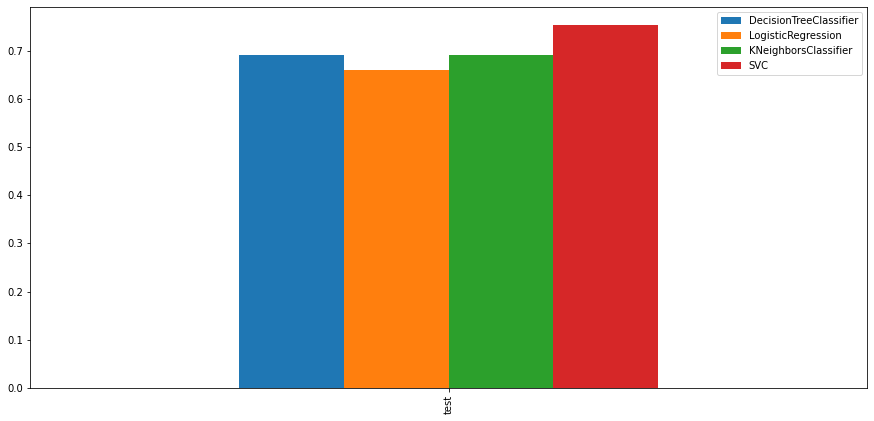

In [ ]:
plt.figure.figsize=(20,30)
df.drop('train', axis=0).plot.bar(figsize=(15,7))

Из базовых модели лучше всего себя показала модель DecisionTreeClassifier на тестовой выборке accuracy равно 0.72

#Проведите сравнительный анализ результатов композиции и базовых моделей между собой.

In [ ]:
df_all_model = pd.DataFrame.from_dict(all_model_dict).drop('train', axis=0)
df_all_model

,DecisionTreeClassifier,LogisticRegression,KNeighborsClassifier,SVC,RandomForestClassifier,LGBMClassifier,CatBoostClassifier,BaggingClassifier
test,0.692308,0.661538,0.692308,0.753846,0.8,0.723077,0.830769,0.692308


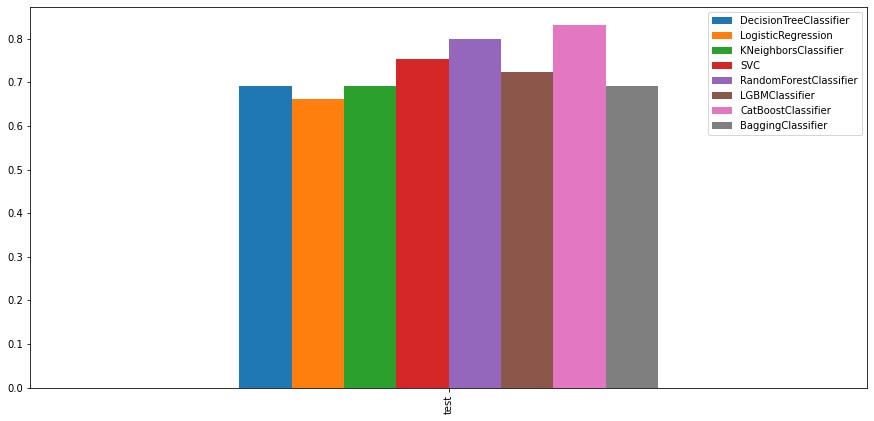

In [ ]:
df_all_model.plot.bar(figsize=(15,7))

In [ ]:
# При сравнение лучших мета и базовых моделей для данной выборки, было выявленно, что 
# CatBoostClassifier (0.83) показала себя лучшей для данного датасета. 